# Nonlinear Regression of the SUPCRTBL database

The SUPCRTBL database was created by members of the Zhu Laboratory at IUB to aid in geochemical modeling of aqueous minerals, in particular Rare Earth Elements (REEs).

An excel copy of the database has been provided, file name "spronsbl_aqeousREE_ref". 

In this file, HKF referes to the Helgeson-Kirkham-Flowers model, which created the coefficients a1, a2, a3, a4, c1, and c2, which are linked to the observed Volume and Cp (Specific heat capacity) of a mineral.

The goal of this nonlinear regression is to find a trend in the data and create a model for predicting values of minerals not yet in the database.

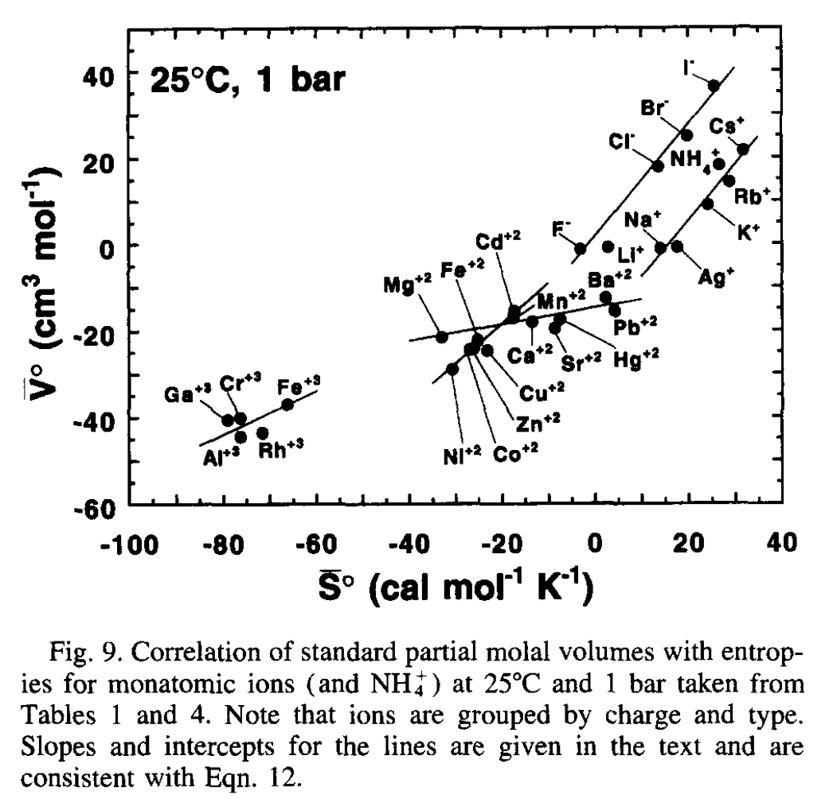

In [1]:
from IPython.display import Image, display
display(Image(filename= 'C:/Users/janel/OneDrive/Documents/IU grad/Classes F23/EAS 690 Advanced Data Science/G690_Test/research_project/images/Shock_fig9.png'))

It has been known that minerals of similar qualities have statistically predictable trends in values such as standard molecular volume (V) and entropy (S), as shown here. In the figure, these trends are visible when grouping major ions by charge. This figure is from Shock et al. (1997). This paper and others like it are the inspiration for searching out new correlations in the fundamental workings of aqueous mineral geochemistry. 


Ref: Shock, E. L., Sassani, D. C., Willis, M., & Sverjensky, D. A. (1997). Inorganic species in geologic fluids: correlations among standard molal thermodynamic properties of aqueous ions and hydroxide complexes. Geochimica et Cosmochimica Acta, 61(5), 907-950.



## The HKF Geochemical Database

First, we will import libraries we need and take a look at the data.

In [1]:
"""import libraries"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import xarray as xr
import torch
import torch.nn as nn
import os


In [2]:
""" Read the HKF data file. """
filename = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\spronsbl_aqueousREE_ref.xlsx"

# read in the data file, 
supcrtbl = pd.read_excel(filename, sheet_name = "core", header = 0, skiprows = 0)

# show the top of the dataset
supcrtbl.head()

,supcrtbl_aqueous_tb_id,Data_source,Species_type,Name,Structural_formula,Abbreviation,Chemical_formula,Reference,Date,"Gibbs_free_energy_of_formation (DGf0, kJ/mol)","Enthalpy_of_formation (DHf0, kJ/mol)","Entropy (S0, J/mol/K)",a1_HKF_coefficient (10^1 J/mol/bar),a2_HKF_coefficient_a2 (10^-2 J/mol),a3_HKF_coefficient (J*K/mol/bar),a4_HKF_coefficient (10^-4 J*K/mol),c1_HKF_coefficient (J/mol/K),c2_HKF_coefficient (10^-4 J*K/mol),"Born_coefficient (omega, 10^-5 J/mol)",Charge
0,314,supcrtbl.dat,Type 6,Rh(SO4)3-4,Rh(SO4)3-4,Rh(SO4)3-4,Rh(1)S(3)O(12)-(4),SS98,30.mar.95,-2150.994,-2595.335,128.867,42.6027,71.4715,-4.1706,-14.5817,129.1011,-57.4668,25.1940,-4
1,336,supcrtbl.dat,Type 6,Ru(SO4)3-4,Ru(SO4)3-4,Ru(SO4)3-4,Ru(1)S(3)O(12)-(4),SS98,30.mar.95,-2112.083,-2553.077,136.817,43.0726,72.6162,-4.4878,-14.6289,129.9605,-56.7932,25.0772,-4
2,1048,supcrtbl.dat,Type 6,UO2(Ac)3-,UO2(CH3COO)3-,UO2(Ac)3-,U(1)C(6)H(9)O(8)-(1),SK93,9,-2102.042,-2543.705,76.567,108.8263,233.1718,-67.6013,-21.2664,1151.9435,360.6001,5.6593,-1
3,279,supcrtbl.dat,Type 6,Pd(SO4)3-4,Pd(SO4)3-4,Pd(SO4)3-4,Pd(1)S(3)O(12)-(4),SS98,28.jul.94,-2091.582,-2526.927,164.850,44.7998,76.8375,-6.1555,-14.8034,134.6867,-53.7761,24.6479,-4
4,335,supcrtbl.dat,Type 6,Ru(SO4)3-3,Ru(SO4)3-3,Ru(SO4)3-3,Ru(1)S(3)O(12)-(3),SS98,30.mar.95,-2071.917,-2486.133,161.921,36.3096,56.1070,1.9887,-13.9465,12.4574,-73.9242,17.6728,-3


The data we are interested in is after the "Date" column. Here we see Gibbs free energy, enthalpy, entropy, the HKF coefficients, the Born coefficient, and the charge of each aqueous mineral species.

Calculating the Born coefficient is rather complicated and involves charge and Gibbs free energy. With this value and several others, there is a very likely possibility that any correlation found in this data will be due to circular reasoning, where one value was used to produce the other. 

The most useful analysis would be to use the chemical formula on each type of data. However, I'm not sure how to design an analysis for the mix of letters. 

Now we will examine the dataset for organizational trends by plotting the major variables (Gibbs free energy, entropy, and enthalpy, which are the most widely used) by mineral ID. This is because the mineral ID is sorted by major cation: all Ag species come first, then Al, then Au, etc.

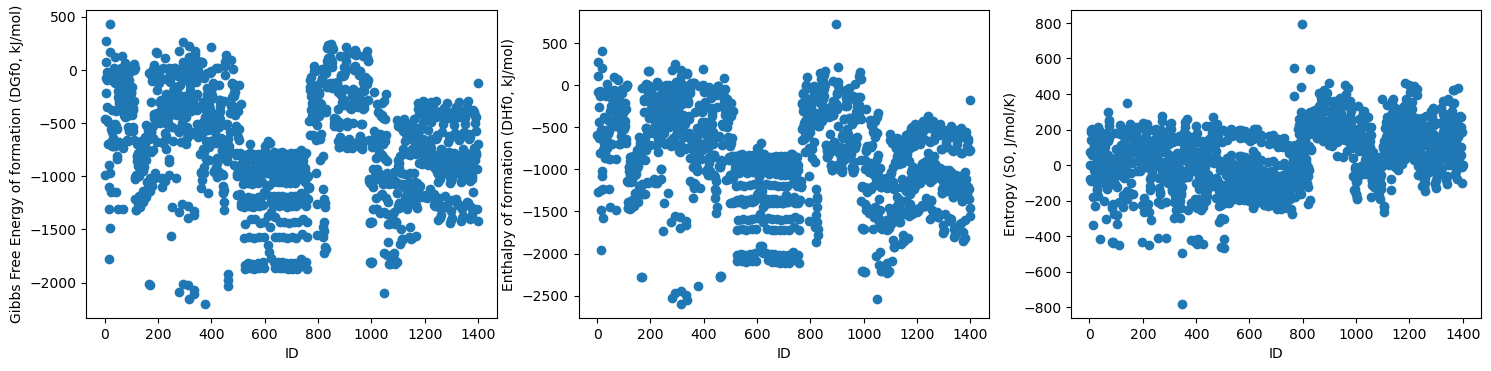

In [ ]:
"""plot data to see if theres any trend in chart organization"""

# plot the data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4))
ax1.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Gibbs_free_energy_of_formation (DGf0, kJ/mol)'])
ax2.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Enthalpy_of_formation (DHf0, kJ/mol)'])
ax3.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Entropy (S0, J/mol/K)'])

ax3.set_xlabel("ID")
ax2.set_xlabel("ID")
ax1.set_xlabel("ID")
ax1.set_ylabel("Gibbs Free Energy of formation (DGf0, kJ/mol)")
ax2.set_ylabel("Enthalpy of formation (DHf0, kJ/mol)")
ax3.set_ylabel("Entropy (S0, J/mol/K)")

plt.show()

This gives us some clues as to how the data is grouped, best seen in plot 1. There are between 4 and 6 major sections. 

## Graphing data

Next, we will see which data shows an apparent trend to choose which to do a nonlinear regression on. I did this by creating graphs of one data column vs another for every paring over the entire dataset.

In [ ]:

"""Define the plot generator function"""

def generate_plot(
        #plot inputs will be column names
        i : str,
        j : str,
        
        #set output directory where plots are saved
        output_dir = "./HKFplots/"):

        # prevent matplotlib from displaying the plot
        plt.ioff()

        # make sure the output directory exists
        os.makedirs(output_dir, exist_ok=True)

        #plot the data
        fig, ax = plt.subplots(figsize=(10, 10))


        #add colors so they dont look really boring
        import random
 
        def random_color_generator():
                r = (random.randint(0, 255))/255
                g = (random.randint(0, 255))/255
                b = (random.randint(0, 255))/255
                return (r, g, b)
 
        random_color = random_color_generator()


        #plot the data
        ax.scatter(supcrtbl[i], supcrtbl[j], color = random_color)

        # set the title of plot and axes
        ax.set_title(f"HKF Correlation of {i} and {j}", fontsize=12)
        ax.set_xlabel(i)
        ax.set_ylabel(j)
        
        # save the plot
        output_file = os.path.join(output_dir, f"plt_{i[:8]}_{j[:8]}.png")
        # save the plot
        fig.savefig(output_file, dpi=300, bbox_inches="tight")

        # close the figure
        plt.close(fig)

        return output_file


By creating a "generate plot" function, we can use a list of the data column headers and run it through a for loop to generate a new plot based on every distinct combination of data columns. The list used for this is shown below.

Plots are also generated to have a random color. 

All plots can be viewed in the "HKFplots" folder within the research folder for this project:

        G690_Test/research_project/HKFplots/

In [ ]:
#create the headers list for the plot generation loop
headers = pd.read_excel(filename, sheet_name = "core").columns
trunc_headers = headers[9:]
print(trunc_headers)

#test generate_plot function before creating 100 figs
generate_plot(trunc_headers[1],trunc_headers[4])

Index(['Gibbs_free_energy_of_formation (DGf0, kJ/mol)',
       'Enthalpy_of_formation (DHf0, kJ/mol)', 'Entropy (S0, J/mol/K)',
       'a1_HKF_coefficient (10^1 J/mol/bar)',
       'a2_HKF_coefficient_a2 (10^-2 J/mol)',
       'a3_HKF_coefficient (J*K/mol/bar)',
       'a4_HKF_coefficient (10^-4 J*K/mol)', 'c1_HKF_coefficient (J/mol/K)',
       'c2_HKF_coefficient (10^-4 J*K/mol)',
       'Born_coefficient (omega, 10^-5 J/mol)', 'Charge'],
      dtype='object')


'./HKFplots/plt_Enthalpy_a2_HKF_c.png'

The test plot created by the generate_plot() function is shown below.

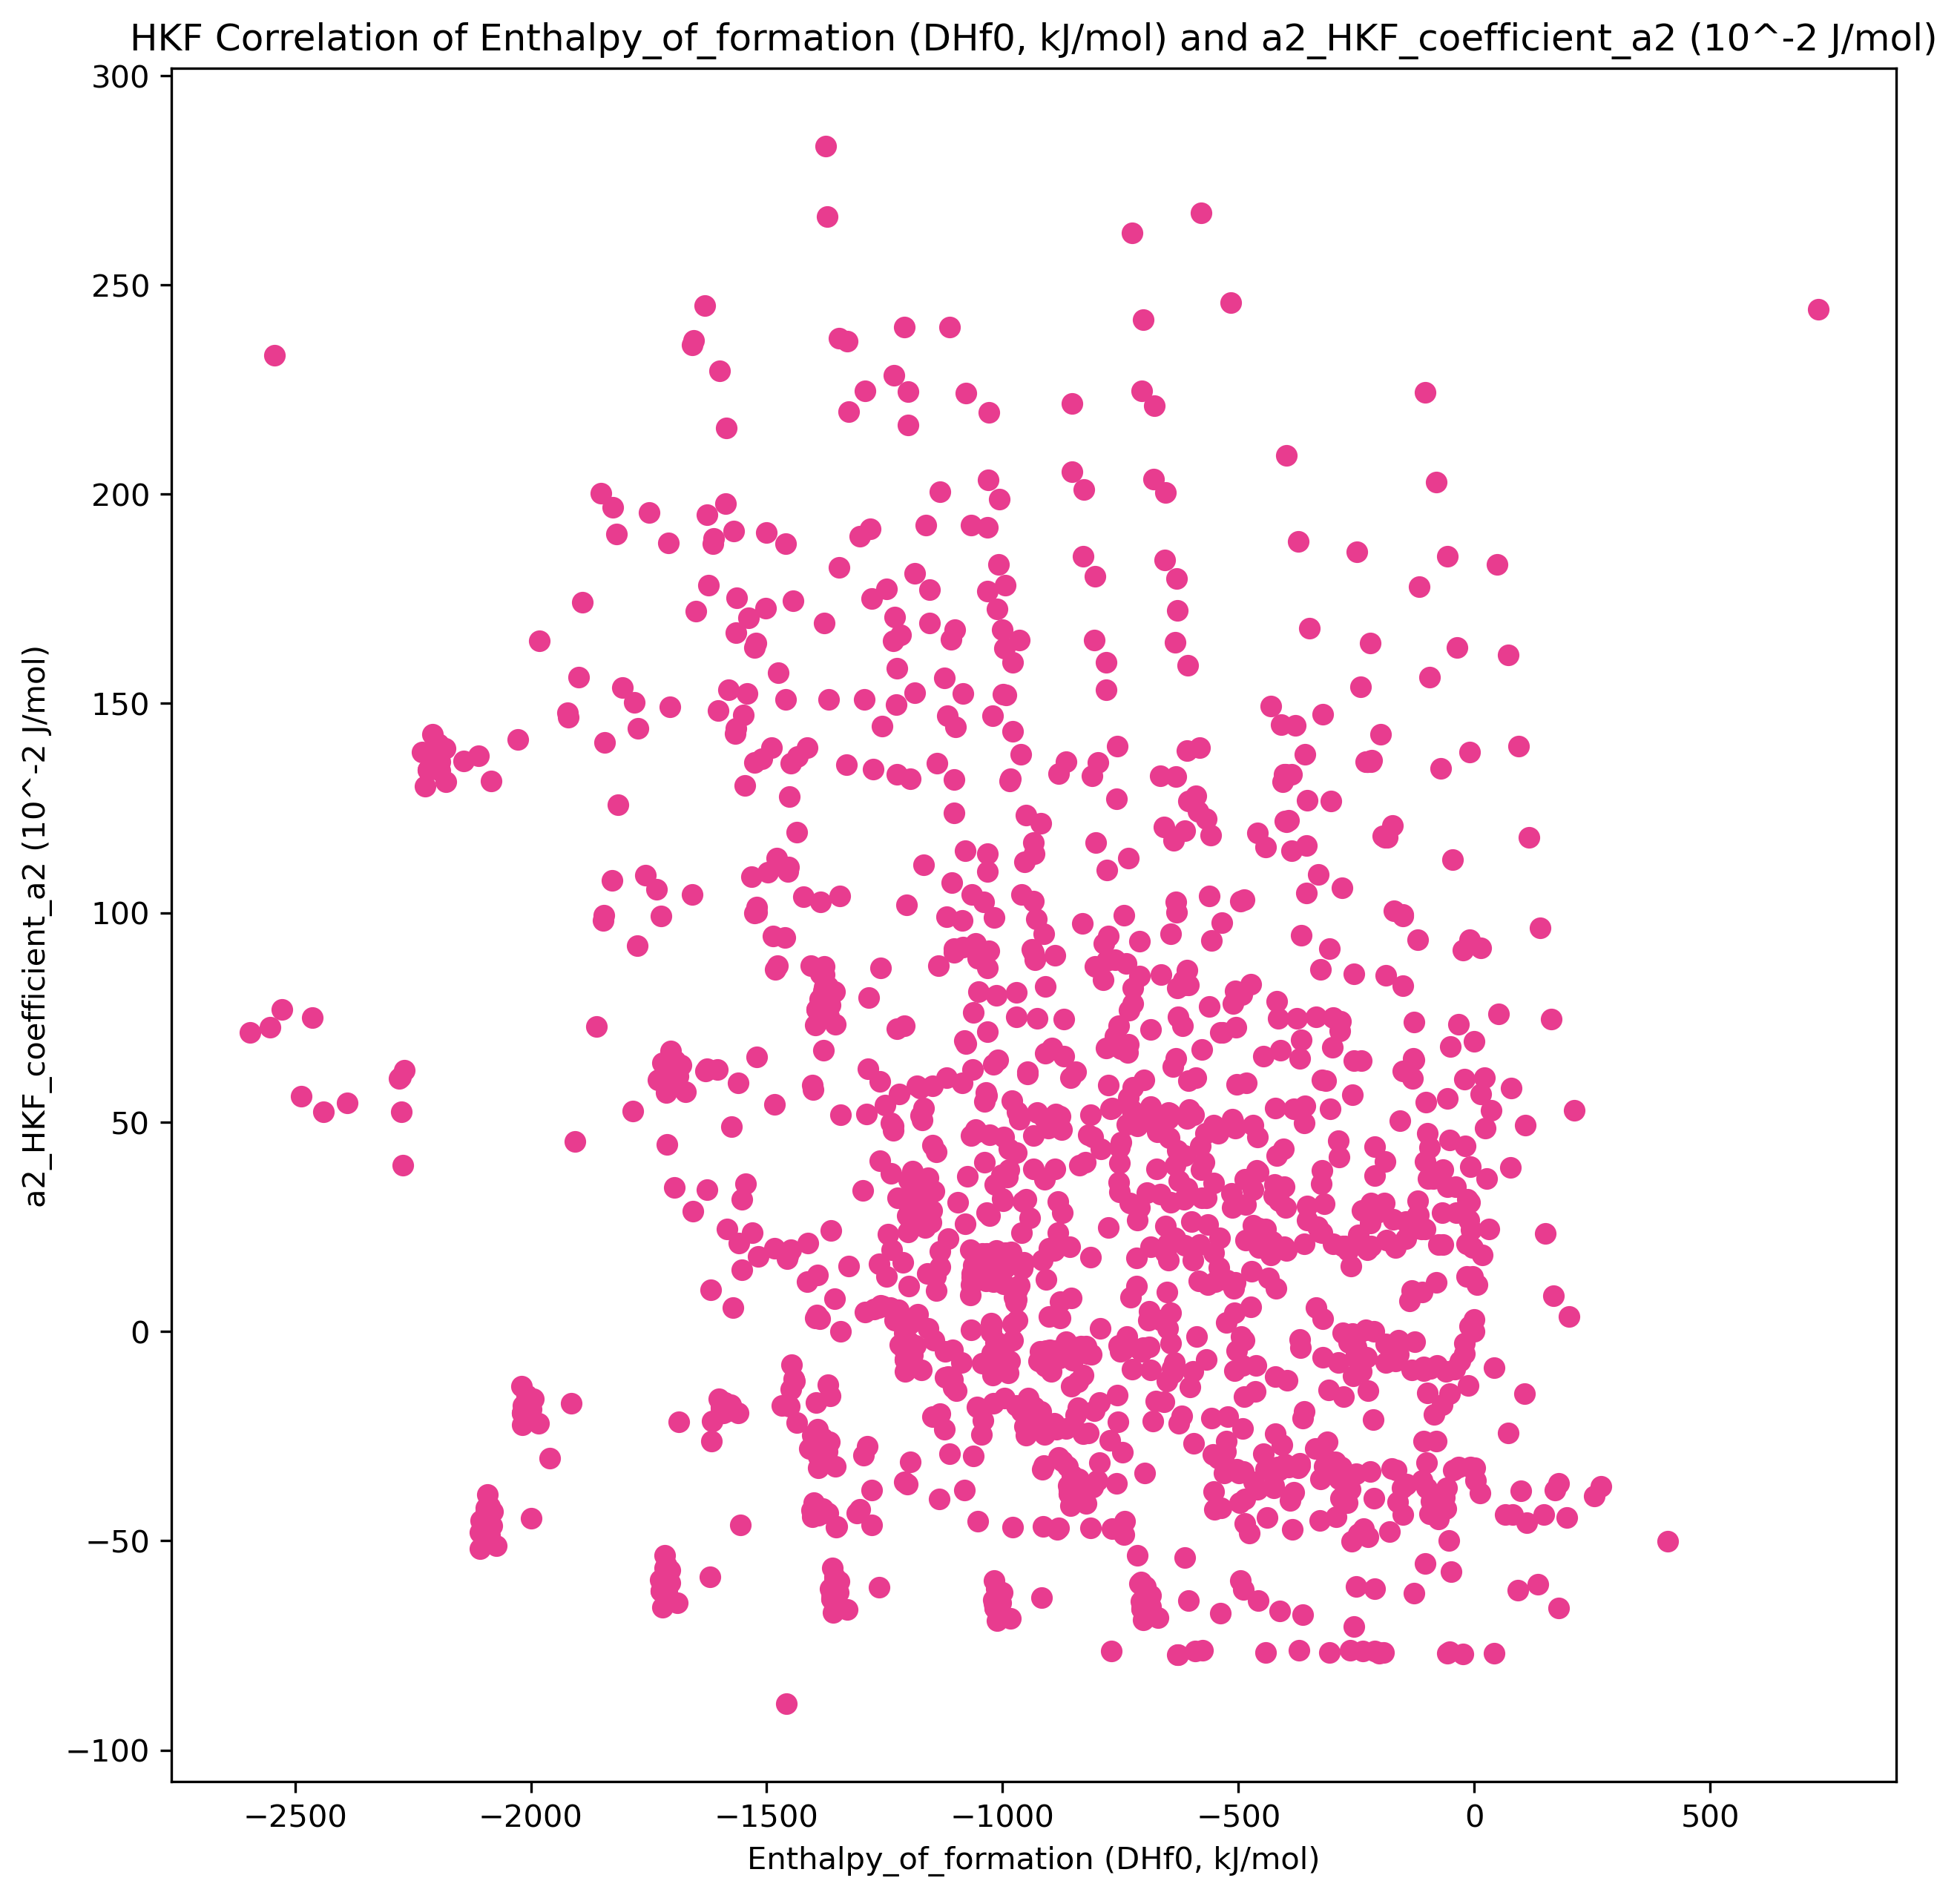

In [ ]:
display(Image(filename= 'C:/Users/janel/OneDrive/Documents/IU grad/Classes F23/EAS 690 Advanced Data Science/G690_Test/research_project/HKFplots/plt_Enthalpy_a2_HKF_c.png') )

Now we will create all plot combinations.

In [ ]:
#execute for loop to create graphs
for label in trunc_headers:
    for label2 in trunc_headers:
        if label == label2:
            None #get rid of 'same x and y' graphs

        else: generate_plot(label, label2)
        #would be nice to keep from making duplicate graphs (ie, x vs y and y vs x are made)

110 Plots were created. However, half of these are repeated plots (plots that show realtionship between the same two variables, but plot 1 has them on x and y and plot 2 has them on y and x). Three of the plots are shown below.

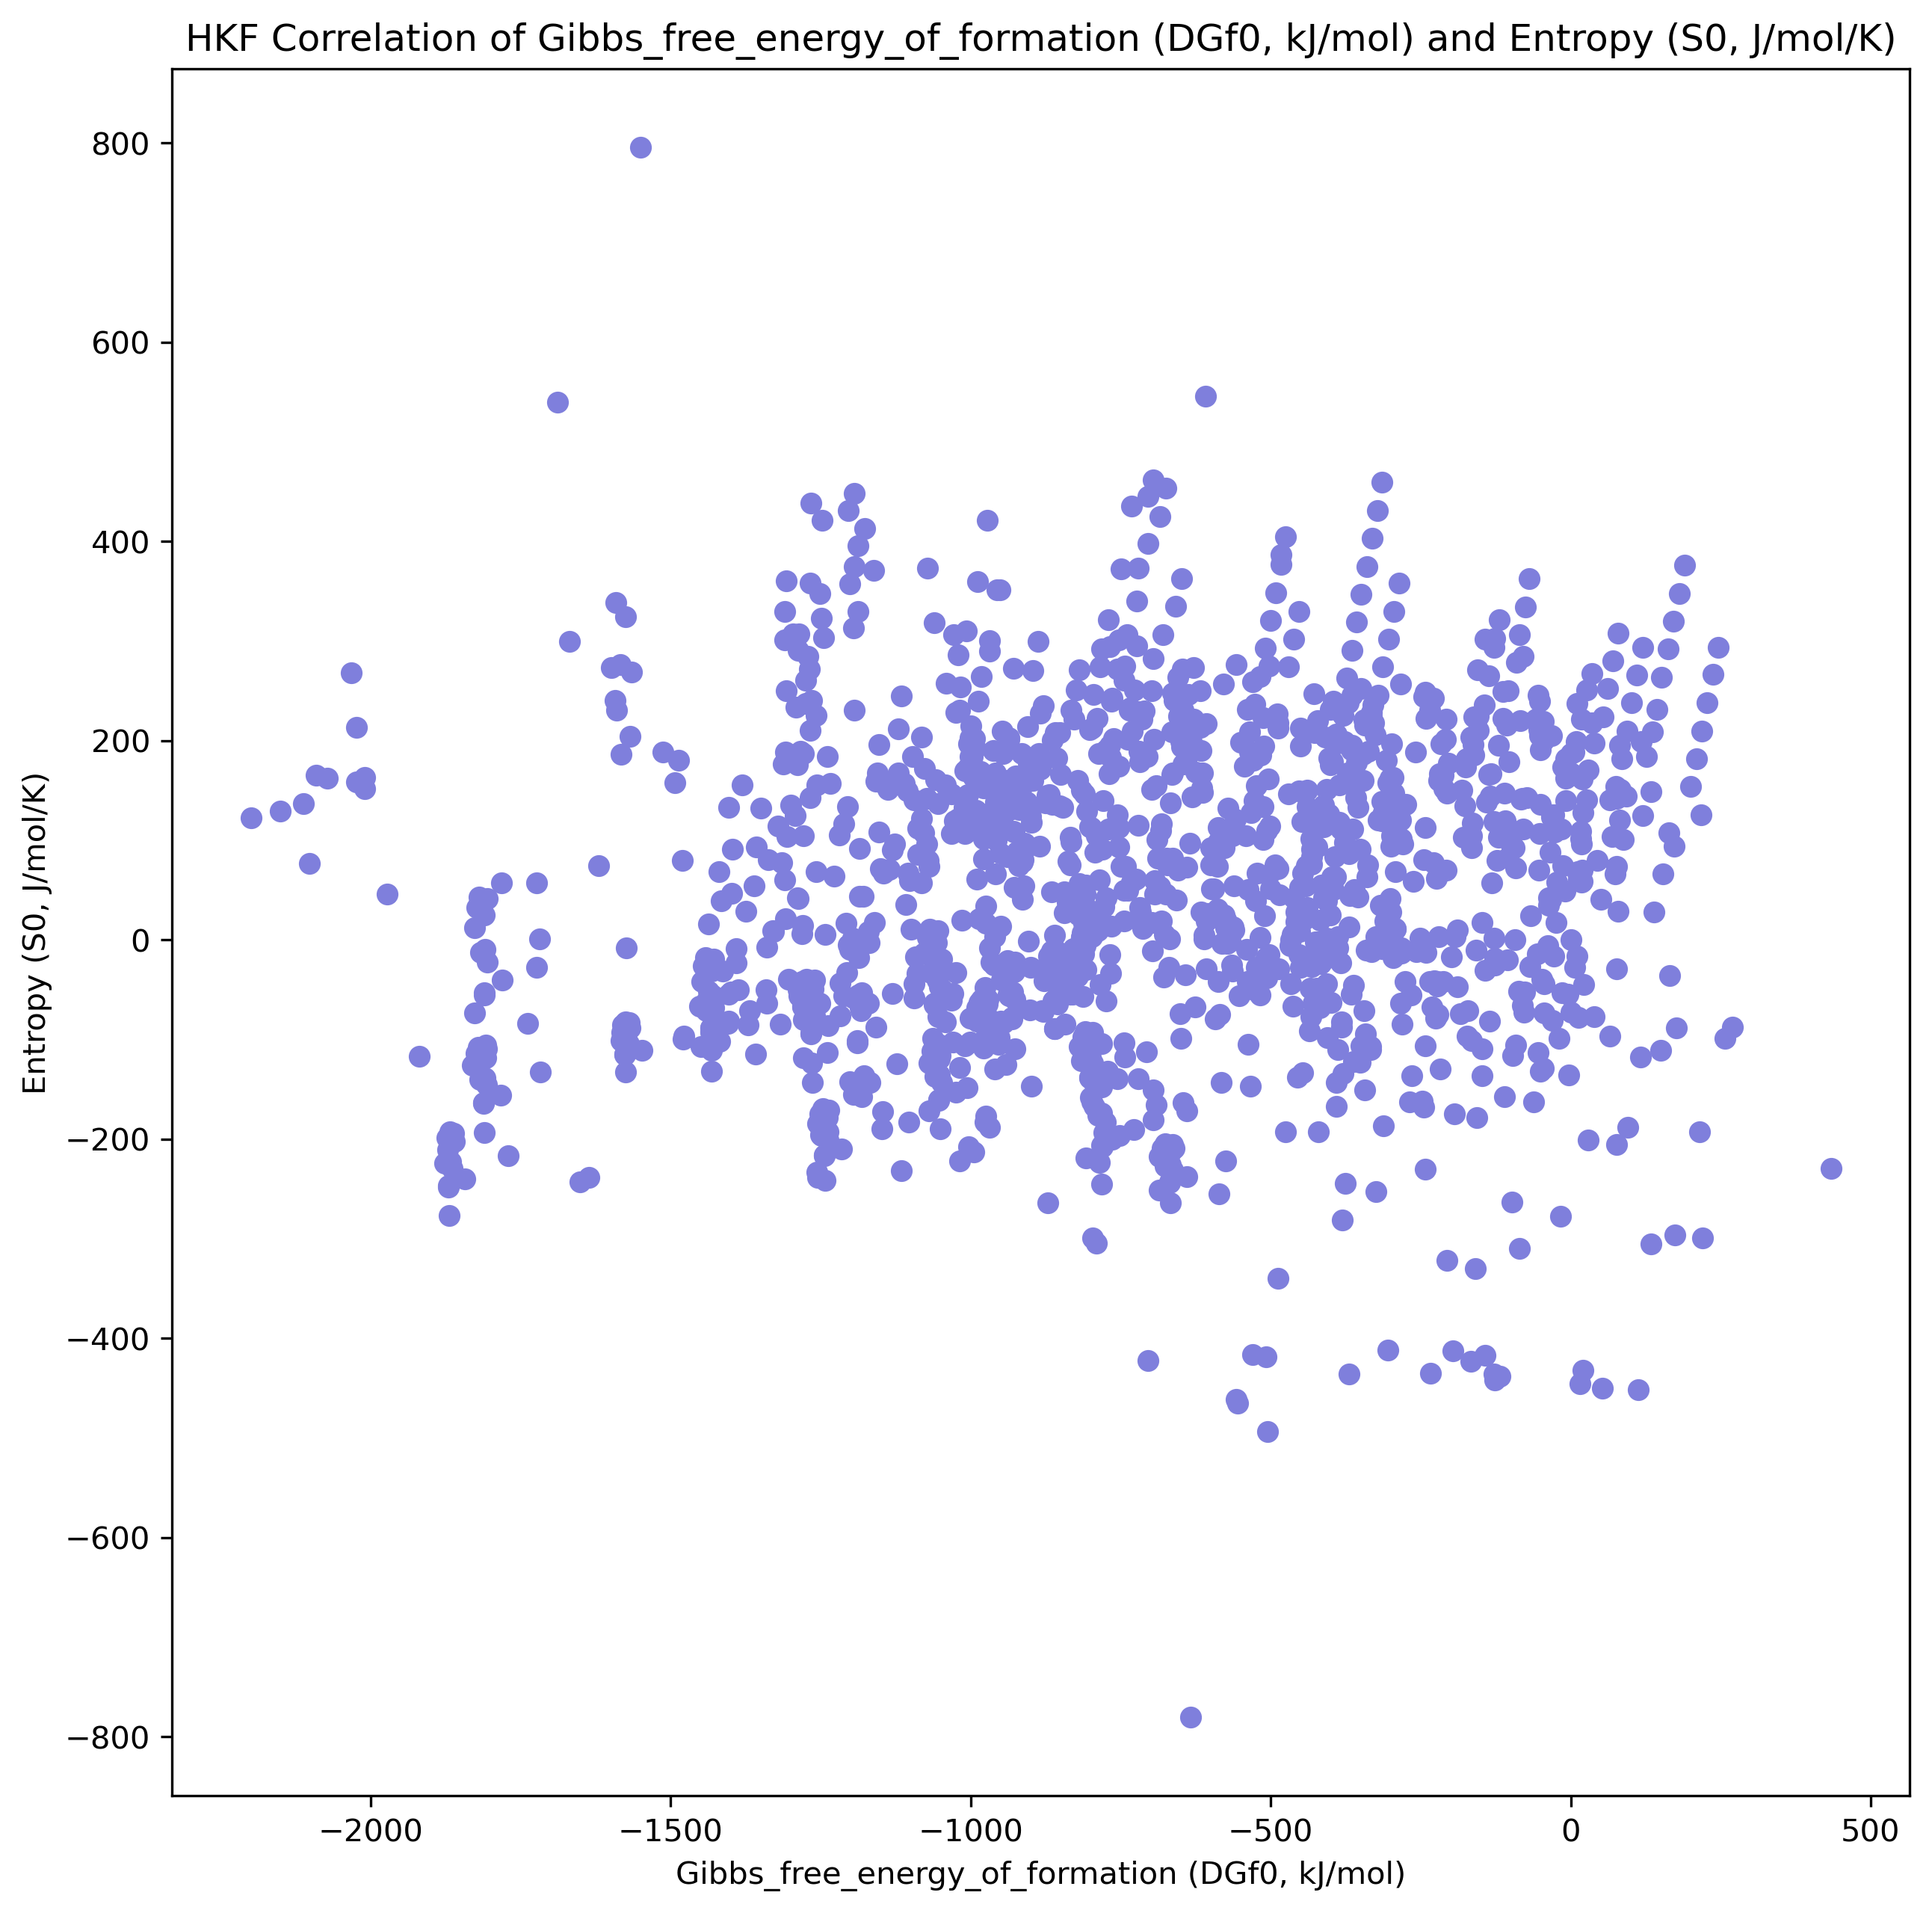

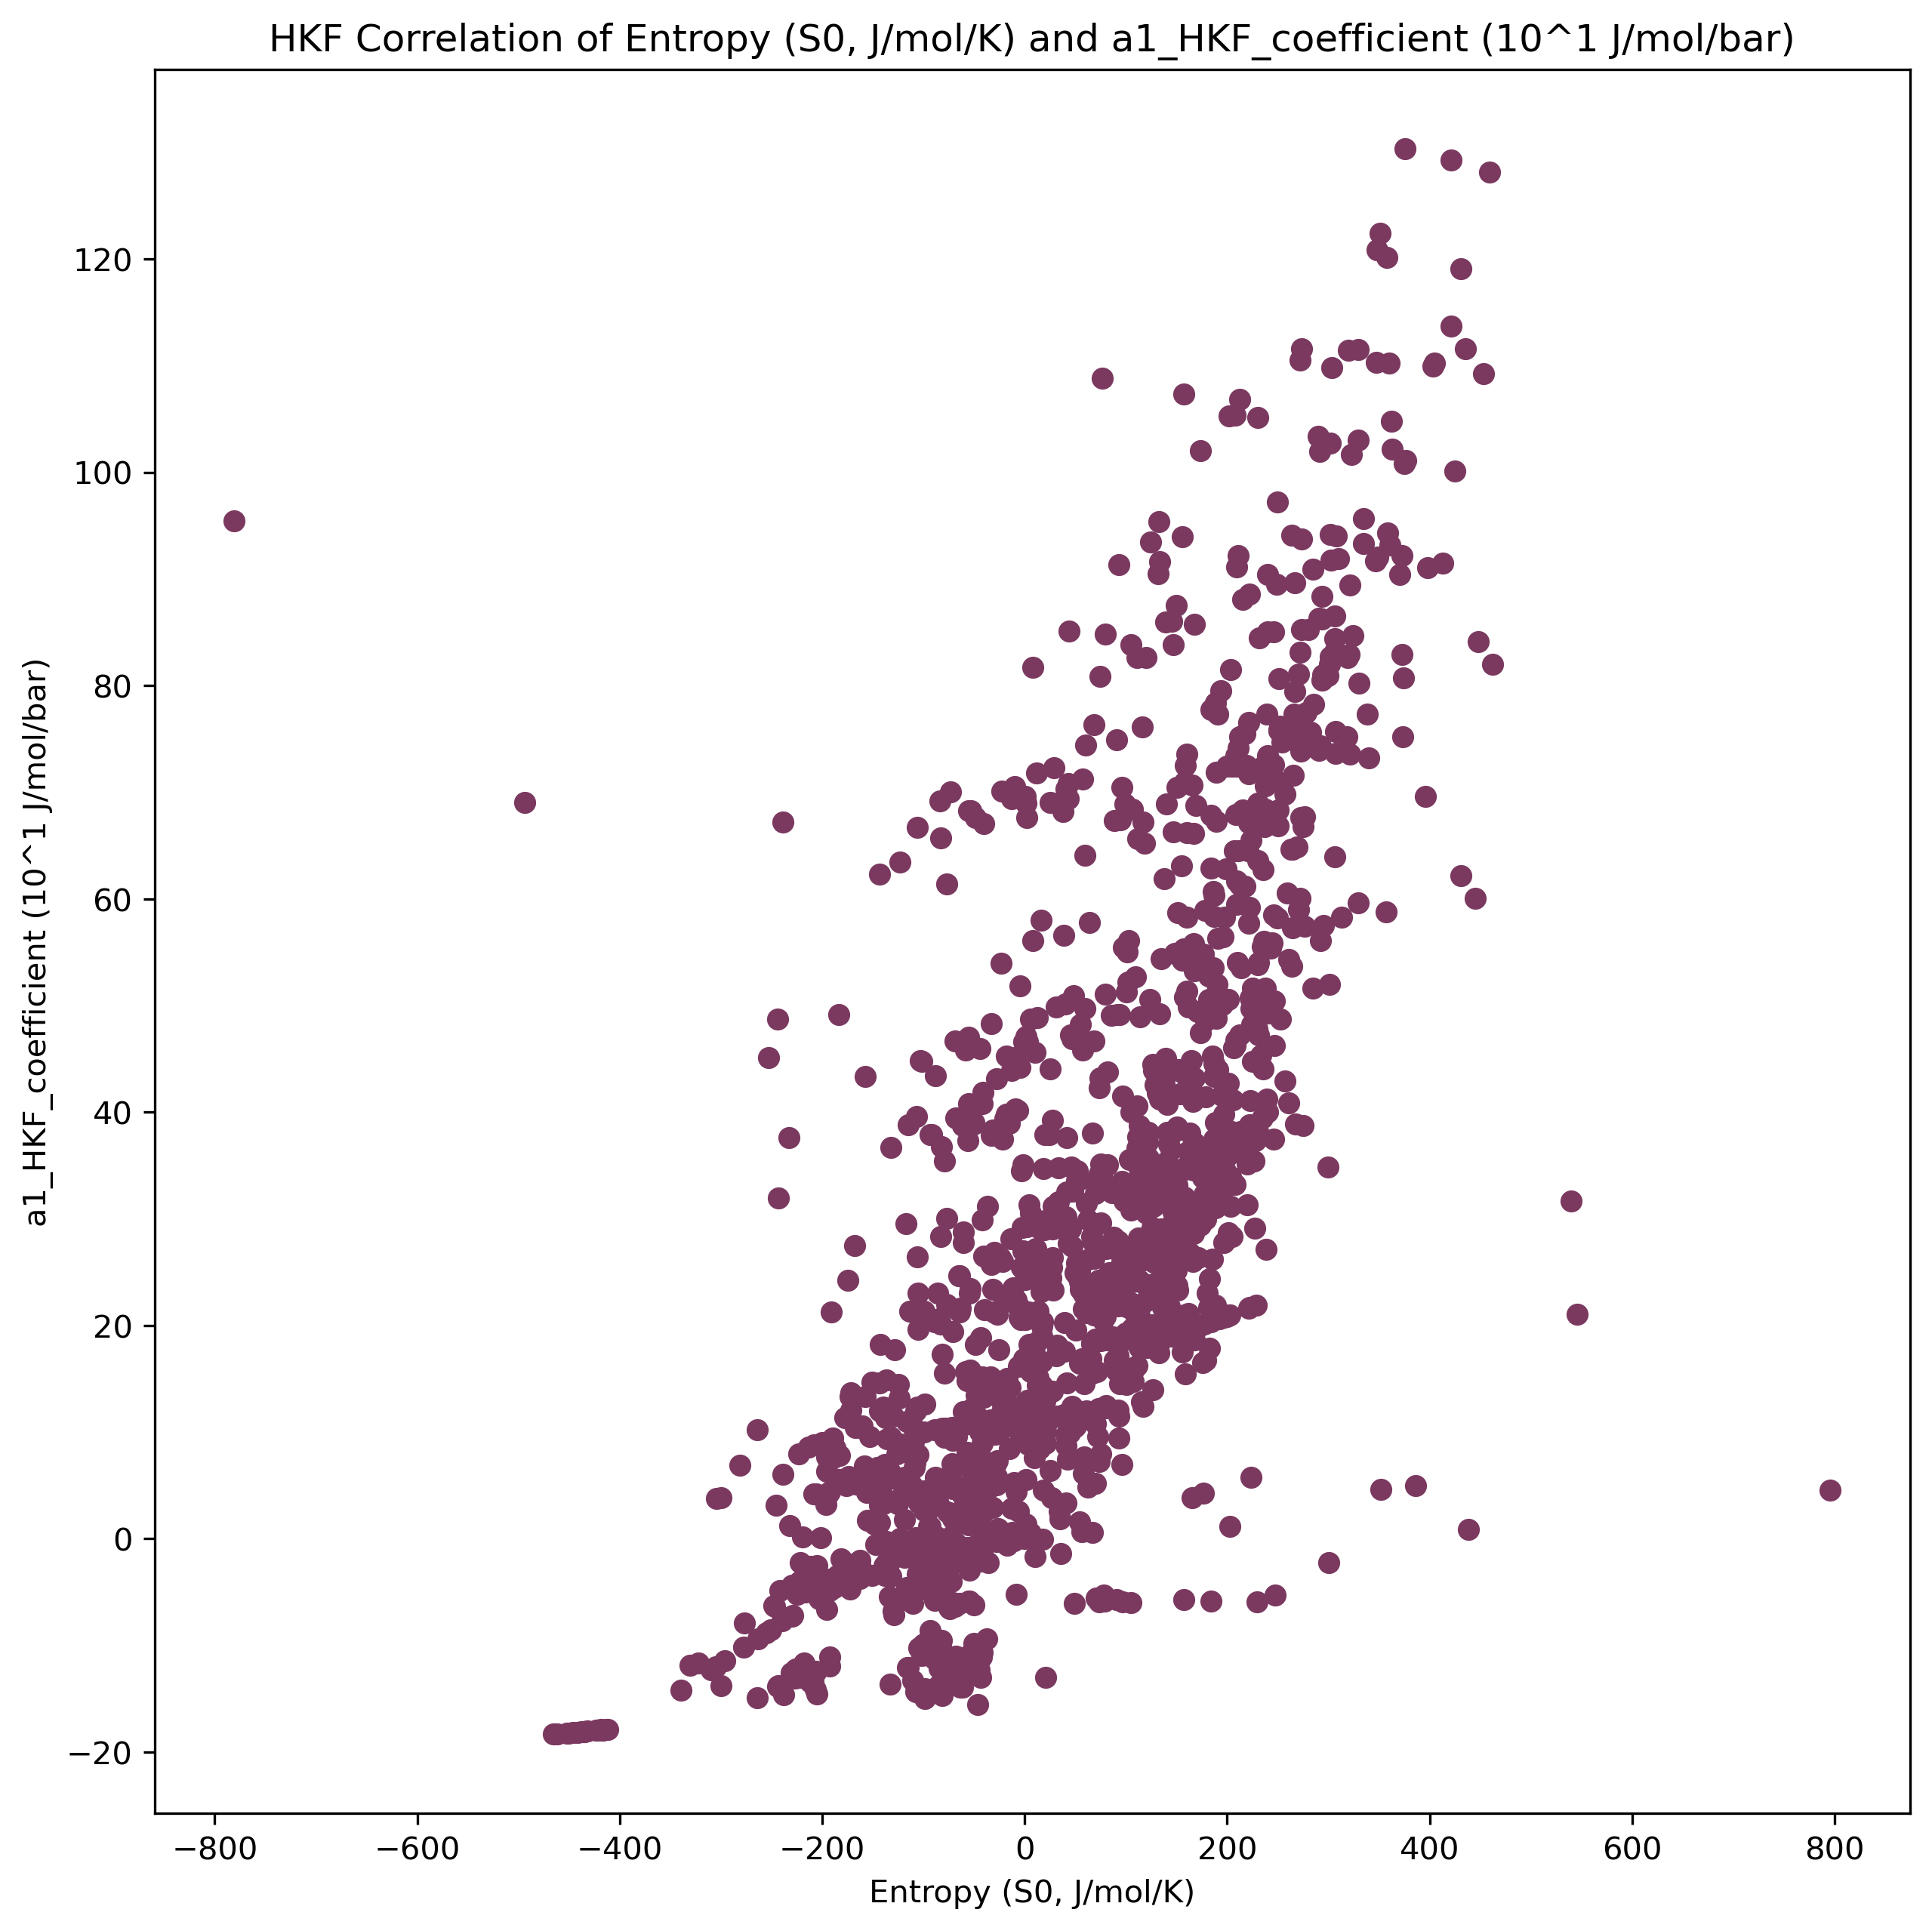

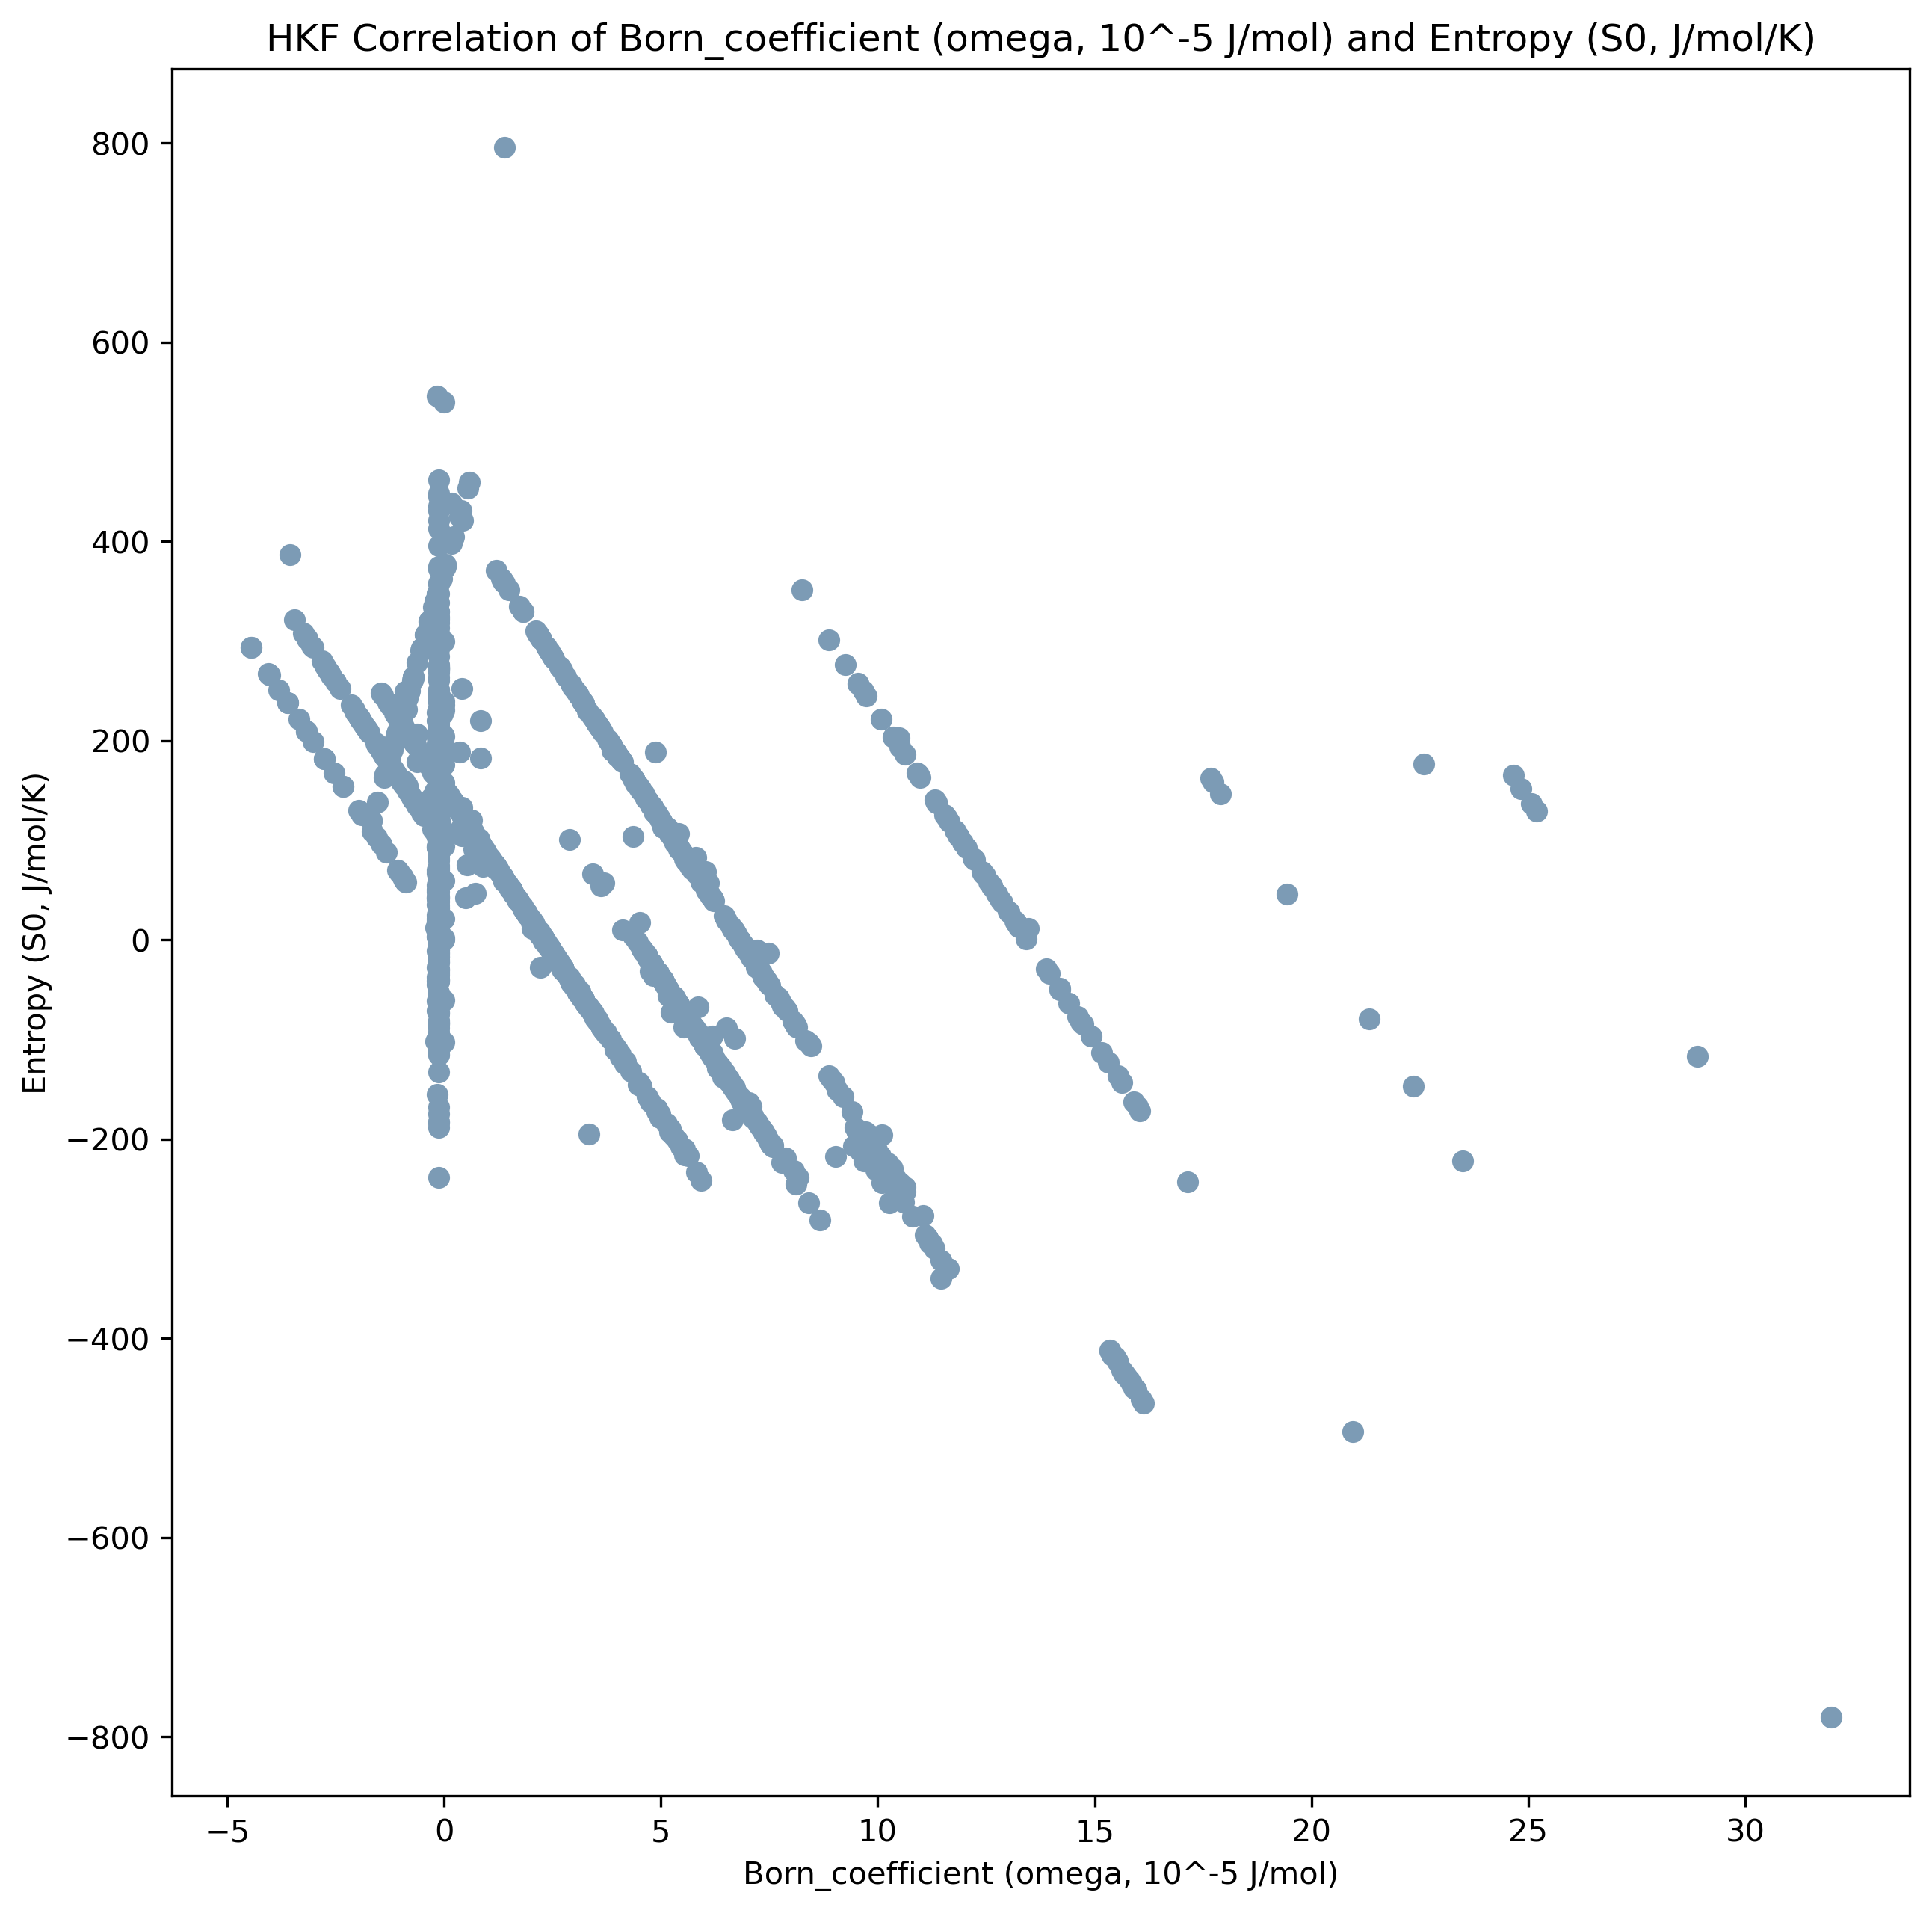

In [ ]:
display(Image(filename= 'C:/Users/janel/OneDrive/Documents/IU grad/Classes F23/EAS 690 Advanced Data Science/G690_Test/research_project/HKFplots/plt_Gibbs_fr_Entropy .png') )
display(Image(filename= 'C:/Users/janel/OneDrive/Documents/IU grad/Classes F23/EAS 690 Advanced Data Science/G690_Test/research_project/HKFplots/plt_Entropy _a1_HKF_c.png') )
display(Image(filename= 'C:/Users/janel/OneDrive/Documents/IU grad/Classes F23/EAS 690 Advanced Data Science/G690_Test/research_project/HKFplots/plt_Born_coe_Entropy .png') )

## Implementing a Neural Network

We will create a neural network for nonlinear regression on one of the plots. I chose to do this using the variable Entropy and the HKF coefficient a1, seen in the middle graph above. 

In [ ]:
#define variables x and y as entropy and a1
x = np.array(supcrtbl['Entropy (S0, J/mol/K)'])
y = np.array(supcrtbl['a1_HKF_coefficient (10^1 J/mol/bar)'])

#check that the data is in the expected format
type(x)

numpy.ndarray

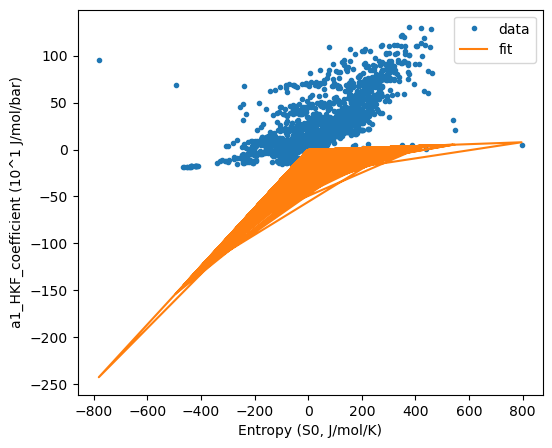

In [ ]:
"""define the neural network and test with limited ReLUs"""

class Net(nn.Module):

    def __init__(self, n_relus : int = 2): #int tels py that n_relus is an integer w default val 2
        #iniitalize the parent class
        super().__init__()

        #create a neural network
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_relus), #layer 1 #n_relus is our output, which is defined as having 2 parts above
            nn.ReLU(), #layer 2
            nn.Linear(n_relus, 1), #layer 3 #both a linear operation on inputs and a sum

        )
    
    def forward(self, x):
        """Define the forward pass; how the network should act like a funciton"""
        out = self.linear_relu_stack(x)
        return  out

""" Show the initial model prediction/fit"""
# convert the x values and y values to pytorch tensors
xt = torch.from_numpy(x).unsqueeze(1).to(torch.float32)
yt = torch.from_numpy(y).unsqueeze(1).to(torch.float32)

# create the 2 relu model
model_2 = Net(n_relus = 2)

# calculate the prdiction
pred = model_2(xt)

# plot the data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, y, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("Entropy (S0, J/mol/K)")
ax.set_ylabel("a1_HKF_coefficient (10^1 J/mol/bar)")
ax.legend()
plt.show()

I've looked at this code for quite a while. I cannot figure out why so many ReLUs are apparently being generated, why they don't come close to matching the data, and why they go back and forth in an odd pattern.

Time to push ahead with model training. I used test and validation sets to evaluate the model.

In [ ]:
""" Train the model the better, but more complicated way. """

# set hyperparameters
learning_rate = 0.01
num_epochs = 20
batch_size = 32
training_fraction = 0.8
test_fraction = 0.1
num_relus = 2

# define the model
model_2 = Net(n_relus = num_relus)

# set the loss function
loss_fn = nn.MSELoss()

# set the optimizer
optim = torch.optim.AdamW(model_2.parameters(), lr = learning_rate)

# set the sizes of the training, test, and validation sets
num_data_total = len(x) #total number of points
n_train = int(training_fraction * num_data_total)
n_test = int(test_fraction  * num_data_total)
n_val = num_data_total - n_train - n_test

print(f"Training on {n_train} points, testing on {n_test} points, and validating on {n_val} points.")

np.random.seed(5984)
i_random_ = np.random.choice(num_data_total, num_data_total, replace=False)

#use random indices to choose indicies for trainig test and val sets
i_train = i_random_[:n_train] #first 80% of random pts
i_test = i_random_[n_train: (n_train + n_test)] #next 10%
i_val = i_random_[(n_train + n_test):]#last 10% of random points

Training on 1114 points, testing on 139 points, and validating on 140 points.


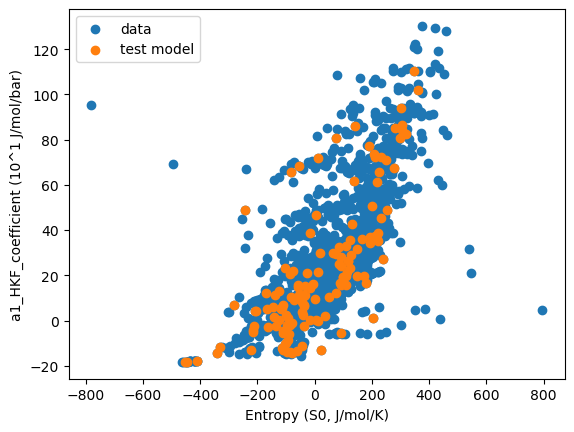

In [ ]:
#chekc to see if sampling is representative shape
fix, ax = plt.subplots()

ax.scatter(x, y, label = "data")
ax.scatter(x[i_test], y[i_test], label = "test model") 
    #ax.scatter(x[i_test], noisy_data, label = "test") 
    #this wasnt working before because 'x and y werent same size' error
    # so I added"[i_test]" after noisy_data. not sure if correct

ax.set_xlabel("Entropy (S0, J/mol/K)")
ax.set_ylabel("a1_HKF_coefficient (10^1 J/mol/bar)")
ax.legend()
plt.show()

So far the test data looks like it is accurately representing the real (Entropy) x (a1) data. 

In [ ]:
"""Create train loop and test loop for model"""

#use random indices to choose indices for training, test, and val sets
from torch.utils.data import TensorDataset, DataLoader
x_train = xt[i_train]
y_train = yt[i_train] 
train_ds = TensorDataset(x_train, y_train)


#use random indices to split data
x_val = xt[i_val]
y_val = yt[i_val]
val_ds = TensorDataset(x_val,y_val)

#PREVIOUSLY MISSING indicies definers -j
x_test = xt[i_test]
test_ds = TensorDataset(x_test, yt[i_test])

#create data loaders
train_dl = DataLoader(train_ds,batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds,batch_size = batch_size, shuffle = False)
val_dl = DataLoader(val_ds,batch_size = batch_size, shuffle = False)

def train_loop(dataloader, model, loss_fn, optim):
    """run a training loop"""
    #set the model to training mode
    model.train()

    #list losses for each
    batch_loss = []
    #loop over batches
    for batch_num, (xx,yy) in enumerate(dataloader):
        #reset zero the gradients
        optim.zero_grad()
        #run the model
        pred = model(xx)
        #calcualte the loss
        loss = loss_fn(pred, yy) #previously yt; may be typo
        #calculate graidents of parameters wrt loss
        loss.backward()
        #update parameters with the optimizer
        optim.step()

        #save loss in list
        batch_loss.append(loss.item())

    #calc average loss 
    avg_loss = np.mean(batch_loss)

    return avg_loss

def test_loop(dataloader, model, loss_fn):
    """run model on test dataset"""
    #model in eval mode
    model.eval()

    #initialize loss
    loss = 0

    with torch.no_grad(): #no need to calcualte gradients when testing
        #loop over the batches
        for xx, yy in dataloader:
            #calculate the prediction
            pred = model(xx)
            #calculate the loss
            loss_partial = loss_fn(pred, yy)

            #update total
            loss = loss+loss_partial

    #return the avg loss accross batches
    average_loss = loss/len(dataloader)
    return average_loss



Finally, with creation of the training loop and test loop, we have what we need to train and evaluate the model. 

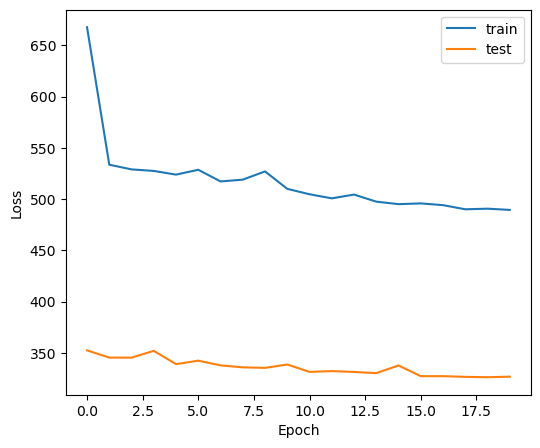

In [ ]:
"""train the model"""
#make lists for tracking the training loss
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    #run the training loop
    train_loss_tmp = train_loop(train_dl, model_2, loss_fn, optim)

    #add loss to the loop
    train_loss.append(train_loss_tmp)


    #run test loop
    loss_tmp = test_loop(test_dl, model_2, loss_fn)

    #add loss to the looop
    test_loss.append(loss_tmp)

#run the test loop
test_loop(test_dl, model_2, loss_fn)

# plot the training and test loss
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(train_loss, label="train")
ax.plot(test_loss, label="test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

Looks like the test loss is significantly better than the training loss. 

However, the loss should be several orders of magnitude lower. The result shown here is most likely because of the odd plotting of the ReLUs above. 

I'm hypothesizing that the test loss is significantly better because it simply has fewer points to compare to how wrong the model is.

Let's plot the model.

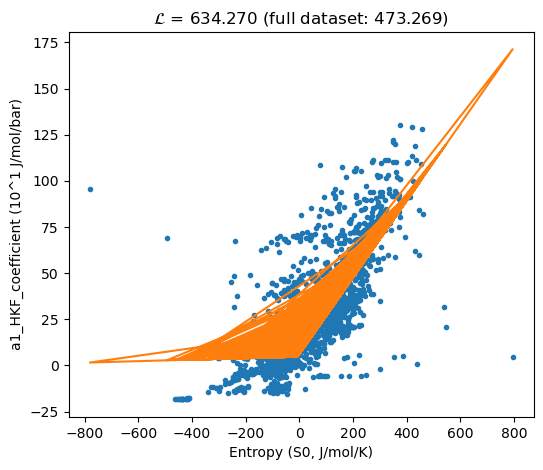

In [ ]:
""" Plot the prediction """
# calculate the prediction
pred = model_2(xt)

# calculate the loss on the validation set
loss = test_loop(val_dl, model_2, loss_fn)

# calculate the loss on the whole dataset
full_loss = loss_fn(pred, yt)


# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, y, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("Entropy (S0, J/mol/K)")
ax.set_ylabel("a1_HKF_coefficient (10^1 J/mol/bar)")
ax.set_title("$\mathcal{L}$ = " +  f"{loss:.3f} (full dataset: {full_loss:.3f})")
plt.show()

I'm not sure what to say about this model in actuality, but in theory, if the model did not have this issue, it would show the Entropy of an aqueous mineral is somewhat correlated to the a1 HKF coefficient. This model instead shows that entropy can be used to calculate a1 with a loss of +600, rendering it unusable.

In order for results to be applicable to predictions, I would have to establish that entropy is not a factor in calculating the HKF coefficients. But even if entropy is used in the calculation, this would a useful study for seeing how well the coefficient represents its data.

In the future, it may be useful to look at minerals grouped by major cation or charge in searching for correlations. 